In [1]:
import torch
import torch.nn as nn
import numpy
import nltk
import re
import string
import matplotlib.pyplot as plt
import random

In [2]:
f = open(r"/home/kandpal/Desktop/Intro to NLP/Language Models/Dataset/shakespeare sonnets.txt","r",encoding='utf-8-sig')

words=''
for i in f:
    words += i
    
# string mein store kiya kyuki string operations karne hai baad mein
# utf-8-sig instead of just utf-8 kyuki kuch toh special characters read karne mein problem aata hai utf-8 ko

In [3]:
words = words.translate(str.maketrans('','',string.digits))
words = words.translate(str.maketrans('','',string.punctuation))
words = str(words.lower())

words = nltk.word_tokenize(words)

# digit punctuation nikalke tokenize kiya

In [4]:
vocab_size = len(set(words))
vocab = set(words)

int2word = {}
word2int = {}

for ids,unique in enumerate(vocab):
    word2int[unique] = ids
    int2word[ids] = unique

In [102]:
class Model(nn.Module):
    def __init__(self,embbsize, vocab_size, hidden_size):
        
        super(Model, self).__init__() 
        self.embeddings = nn.Embedding(vocab_size, embbsize)
        self.embeddings.requires_grad = False
        self.lstm = nn.LSTM(embbsize, hidden_size, num_layers=2, dropout=0.5, batch_first=True)
        self.fc = nn.Linear(hidden_size,vocab_size)

    def forward(self, x):
        
        word_vec = self.embeddings(x)
        word_vec = torch.unsqueeze(word_vec, 0)
        # lstm ko (1,1,inputsize) chahiye hota hai but sirf (1,inputsize) hai abhi so unsqueeze
        output, hidden = self.lstm(word_vec)    
        out = self.fc(output)
        
        return out,hidden

In [176]:
net = Model(embbsize = 200, vocab_size = vocab_size, hidden_size = 1024).cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-4, amsgrad=True)
lossfn = nn.CrossEntropyLoss() 

In [172]:
def save_checkpoint(state, filename='model_checkpoint.pth'):
    print('Saved checkpoint')
    torch.save(state, filename)
    
    
def load_checkpoint(checkpoint):
    print('Loading checkpoint')
    torch.load(checkpoint['state_dict'])

In [217]:
costs = []
total_loss = []
epoch = 40

for i in range(epoch):
    
    epoch_loss = 0
    
    for j,cor_word in enumerate(words):
        
        if j==(len(words)-1): # if last word then break because i dont have a target for it
            break
        
        inp_idx = word2int[words[j]]
        inp_idx = torch.tensor([inp_idx]).cuda()
            
        ytarget = torch.tensor([word2int[words[j+1]]], dtype = torch.int64)
            
        output, hidden1 = net(inp_idx)              # output shape is ([1,1,3119])
        
        output = output.view(1,-1)                  # shape is ([1,3119])  
            
        loss = lossfn(output.cuda(),ytarget.cuda())
        costs.append(loss)
        epoch_loss += loss.item()
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    total_loss.append(epoch_loss)
    
    if (i+1)%5==0:
        print(f'epoch number {i+1} | latest epoch loss = {epoch_loss} | latest loss per word = {epoch_loss / len(words)}')
        checkpoint = {'state_dict' : net.state_dict()}
        save_checkpoint(checkpoint)

epoch number 5 | latest epoch loss = 102339.11439156532 | latest loss per word = 5.600257983559446
Saved checkpoint
epoch number 10 | latest epoch loss = 91526.31574296951 | latest loss per word = 5.008553997098036
Saved checkpoint
epoch number 15 | latest epoch loss = 81805.31275141239 | latest loss per word = 4.47659586031588
Saved checkpoint


KeyboardInterrupt: 

<function matplotlib.pyplot.show(*args, **kw)>

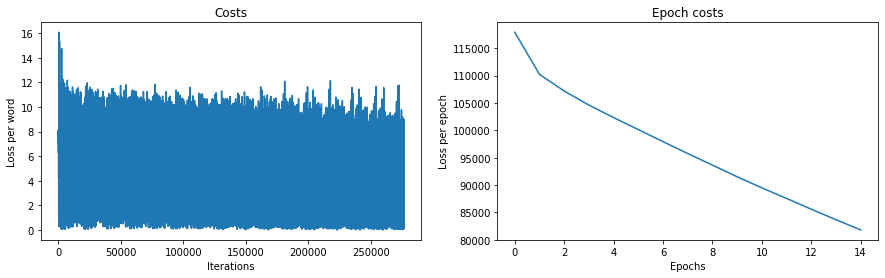

In [219]:
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(costs)
plt.title('Costs')
plt.xlabel('Iterations')
plt.ylabel('Loss per word')

plt.subplot(122)
plt.plot(total_loss)
plt.title('Epoch costs')
plt.xlabel('Epochs')
plt.ylabel('Loss per epoch')

plt.show

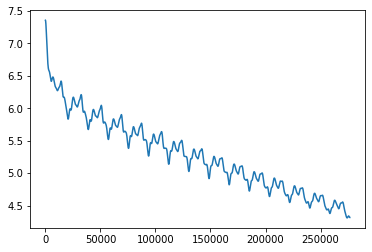

In [220]:
from scipy.ndimage import gaussian_filter

cost = [float(i.detach().cpu()) for i in costs]
smooth = gaussian_filter(cost,800)
plt.plot(smooth)

In [266]:
# GENERATION

net.eval()

i = 1
inp_idx = torch.randint(vocab_size, (1,))
result = ''

while(1):
    
    inp_idx = inp_idx.reshape(-1)
    result += ' ' + int2word[inp_idx.item()]
    
    i += 1
    if i==100:
        break
    if i%7 == 0:
        print(result,'\n')
        result = ''
        
    prediction, _ = net(inp_idx.cuda())
    prediction = prediction.reshape(-1)
    prediction = nn.functional.softmax(prediction, dim=0)
    
    output, out_idx = prediction.topk(5)
    out_idx = random.choice(out_idx)
    inp_idx = out_idx
    
# print(result)

 morning it self to my love 

 you as the sun and make war 

 with me and beauty ’ s own 

 in thy love and this huge we 

 desire of thee my self thy beauty 

 of thy beauty still weep that is 

 so thou art so should look in 

 the time that thou art twice in 

 love is the day and in your 

 own hand takes from you should my 

 self thy self with his beauty and 

 in my mind that which steals a 

 little of my mind and in thy 

 sweet semblance to be a woman ’ 

